In [1]:
import urllib, json
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
bg = '#11134A'
accent = '#202289'
txt = '#FAF9F1'
verde = '#66C2A5'

mpl.rcParams['text.color'] = txt
mpl.rcParams['axes.labelcolor'] = txt
mpl.rcParams['xtick.color'] = txt
mpl.rcParams['ytick.color'] = txt
mpl.rcParams['axes.facecolor'] = bg
mpl.rcParams['axes.edgecolor'] = txt

In [3]:
areas = gpd.read_file( '../../data/aree.geojson' )
areas = areas[["geometry", "NOME_AT"]] # shows epsg:3004, but it's wrong
areas = areas.rename(columns = { "NOME_AT" : "frazione" })
areas = areas.set_crs( "epsg:4326", allow_override = True )
areas = areas.to_crs( epsg = 32633 ) #utm

In [4]:
points_url = 'https://opendata.comune.ra.it/dataset/cc8dc392-f550-4396-814a-e4946f63960a/resource/f12bade0-c3e9-46c2-ad37-492238831dd0/download/rete-ecologica.geojson'
points_response = urllib.request.urlopen(points_url)
points_data = json.loads(points_response.read())
# print(points_data)
points = gpd.GeoDataFrame.from_features(points_data)
# print(points.crs)
points = points.set_crs('epsg:3004')
points = points.to_crs(epsg = 32633)
points = points[['geometry', 'OBJECTID']]
# print(points.head(2))
# points.plot()

<AxesSubplot:>

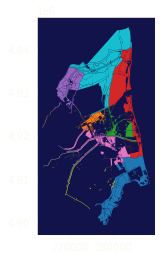

In [5]:
coverage = areas.overlay( points, how = 'intersection' )
coverage.plot( column = 'frazione' )

In [6]:
coverage = coverage.dissolve( by = 'frazione', aggfunc = 'sum' )
coverage = coverage.rename( columns = { 'geometry' : 'rete_geometry' } )
coverage = coverage.merge( areas, on = 'frazione' )
coverage['rete_kmq'] = coverage['rete_geometry'].area / 10**6 # km
coverage['geometry_kmq'] = coverage['geometry'].area / 10**6
coverage['covered_percent'] = 100 * coverage['rete_kmq'] / coverage['geometry_kmq']
coverage = coverage.drop( columns = ['OBJECTID'] )
print(coverage.head(3))

        frazione                                      rete_geometry  \
0    CASTIGLIONE  MULTIPOLYGON (((278224.684 4899294.667, 278221...   
1  CENTRO URBANO  MULTIPOLYGON (((273460.830 4921334.669, 273418...   
2        DARSENA  MULTIPOLYGON (((278314.335 4920169.209, 278292...   

                                            geometry   rete_kmq  geometry_kmq  \
0  POLYGON ((286726.373 4915066.675, 286750.492 4...  50.828100     80.437160   
1  POLYGON ((278046.280 4925082.213, 278051.049 4...   8.637046     21.155808   
2  POLYGON ((281218.174 4926652.414, 281326.598 4...  13.023490     41.587972   

   covered_percent  
0        63.189824  
1        40.825888  
2        31.315520  


In [12]:
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

cdict = {
    'red' : ((0.0, inter_from_256(17), inter_from_256(17)),
            (1.0, inter_from_256(0), inter_from_256(0))),
    'green' : ((0.0, inter_from_256(19), inter_from_256(19)),
            (1.0, inter_from_256(155), inter_from_256(155))),
    'blue' : ((0.0, inter_from_256(74), inter_from_256(74)),
            (1.0, inter_from_256(119), inter_from_256(119)))
}
g_grd = matplotlib.colors.LinearSegmentedColormap('g_grd', segmentdata=cdict)

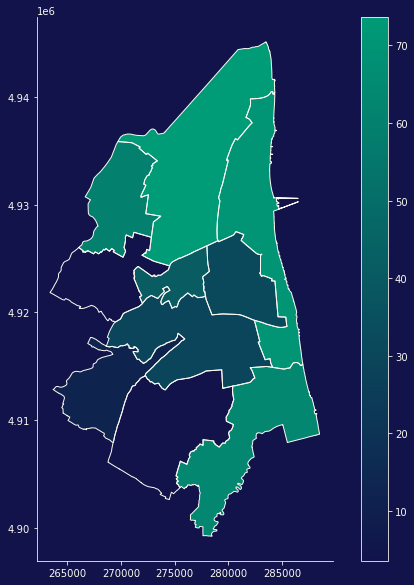

In [13]:
map = coverage[['geometry', 'covered_percent']]
fig, ax = plt.subplots( figsize = (10, 10) )
map.plot( ax = ax, column = 'covered_percent', cmap = g_grd, legend = True )
areas.plot( ax = ax, color = 'none', edgecolor = txt )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.patch.set_facecolor(bg)

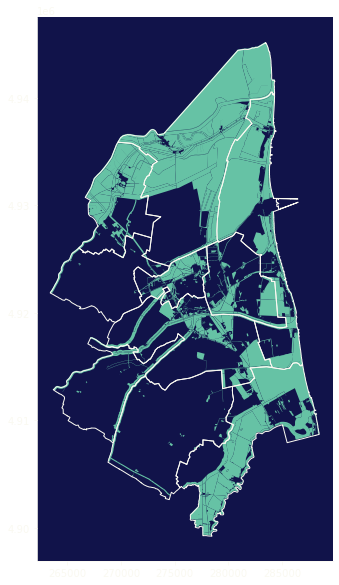

In [9]:
fig, ax = plt.subplots( figsize = (10, 10) )
points.plot(ax = ax, color = verde)
areas.plot(ax = ax, color = 'none', edgecolor = txt)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)